# 利用回归问题进行超参数搜索

In [1]:
# 导入
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl,np,pd,sklearn,tf,keras:
    print(module.__name__,module.__version__)

2.0.0
sys.version_info(major=3, minor=6, micro=10, releaselevel='final', serial=0)
matplotlib 3.1.2
numpy 1.18.1
pandas 0.25.3
sklearn 0.22.1
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


### 数据读取

In [2]:
# 导入数据集 房价预测
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [3]:
# 切分数据集
from sklearn.model_selection import train_test_split

x_train_all,x_test,y_train_all,y_test = train_test_split(
    housing.data,housing.target,random_state=7)
x_train,x_valid,y_train,y_valid = train_test_split(
    x_train_all,y_train_all,random_state=11)

print(x_train.shape,y_train.shape)
print(x_valid.shape,y_valid.shape)
print(x_test.shape,y_test.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [4]:
# 对数据进行归一化
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

### 模型构建
#### 手动实现超参数搜索

简化问题：只针对learning_rate进行超参数搜索

learning_rate：[1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2]

学习率用于参数更新上：W = W + grad * learning_rate

In [5]:
# 手动实现学习率搜索
learning_rates = [1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2]
histories = []
for lr in learning_rates:
    model = keras.models.Sequential([
        keras.layers.Dense(30, activation='relu',input_shape=x_train.shape[1:]),
        keras.layers.Dense(1)
    ])

    optimizer = keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss='mean_squared_error',optimizer=optimizer)

    callbacks = [keras.callbacks.EarlyStopping(patience=5,min_delta=1e-2)]
    history = model.fit(x_train_scaled,y_train,epochs=100,
                        validation_data=(x_valid_scaled,y_valid),
                        callbacks=callbacks)
    histories.append(history)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 2s 189us/sample - loss: 2.9827 - val_loss: 2.5992
Epoch 2/100
11610/11610 [==============================] - 1s 112us/sample - loss: 2.0778 - val_loss: 1.8459
Epoch 3/100
11610/11610 [==============================] - 1s 112us/sample - loss: 1.5144 - val_loss: 1.4004
Epoch 4/100
11610/11610 [==============================] - 2s 131us/sample - loss: 1.1975 - val_loss: 1.1572
Epoch 5/100
11610/11610 [==============================] - 1s 121us/sample - loss: 1.0241 - val_loss: 1.0187
Epoch 6/100
11610/11610 [==============================] - 1s 117us/sample - loss: 0.9178 - val_loss: 0.9268
Epoch 7/100
11610/11610 [==============================] - 1s 116us/sample - loss: 0.8437 - val_loss: 0.8582
Epoch 8/100
11610/11610 [==============================] - 1s 113us/sample - loss: 0.7816 - val_loss: 0.7995
Epoch 9/100
11610/11610 [==============================] - 1s 125us/sample - lo

Learning Rate: 0.0001


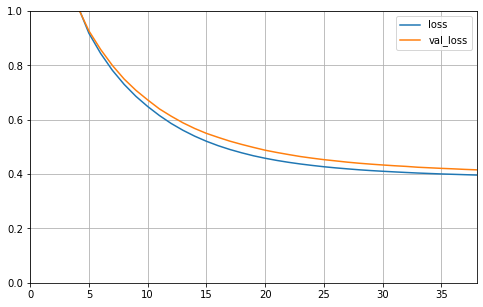

Learning Rate: 0.0003


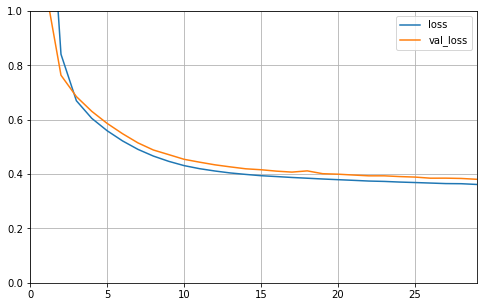

Learning Rate: 0.001


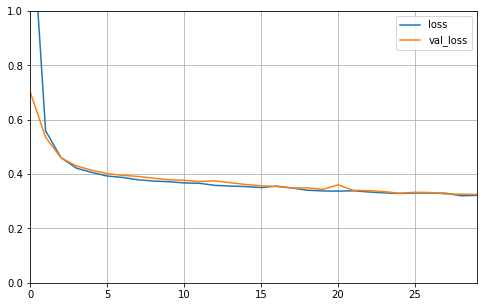

Learning Rate: 0.003


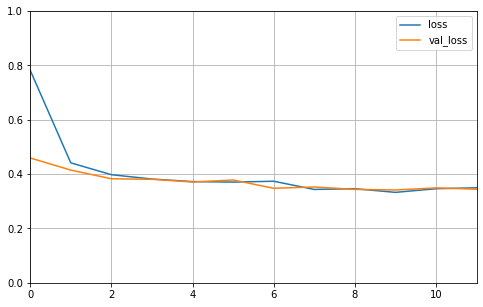

Learning Rate: 0.01


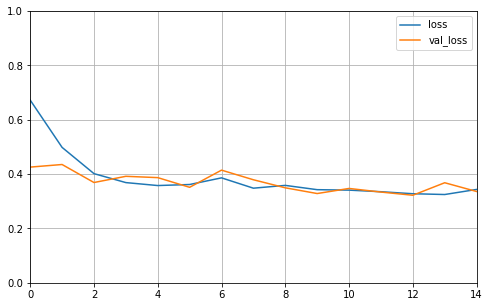

Learning Rate: 0.03


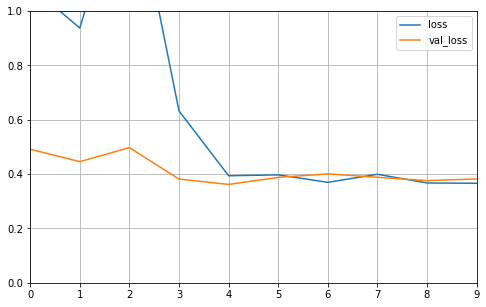

In [6]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()
    
for lr, history in zip(learning_rates, histories):
    print("Learning Rate: " + str(lr))
    plot_learning_curves(history)

#### 使用sklearn实现超参数搜索

使用sklearn中的RandomizedSearchCV实现

步骤：
1. 将tfkeras model 转化为 sklearn model
2. 定义参数集合
3. 搜索参数

In [7]:
# sklearn实现随机超参数搜索
# 1.转化为sklearn model
def build_model(hidden_layers = 1, layer_size = 30, learning_rate = 3e-3):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(layer_size, activation='relu',input_shape=x_train.shape[1:]))
    for _ in range(hidden_layers - 1):
        model.add(keras.layers.Dense(layer_size,activation='relu'))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.Adam(learning_rate)
    model.compile(loss='mse',optimizer=optimizer)
    return model

sklearn_model = keras.wrappers.scikit_learn.KerasRegressor(build_model)
callbacks = [keras.callbacks.EarlyStopping(patience=5,min_delta=1e-2)]
history = sklearn_model.fit(x_train_scaled,y_train,epochs=100,
                            validation_data=(x_valid_scaled,y_valid),
                            callbacks=callbacks)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 2s 134us/sample - loss: 0.8353 - val_loss: 0.4933
Epoch 2/100
11610/11610 [==============================] - 1s 106us/sample - loss: 0.4418 - val_loss: 0.4220
Epoch 3/100
11610/11610 [==============================] - 1s 105us/sample - loss: 0.3922 - val_loss: 0.3982
Epoch 4/100
11610/11610 [==============================] - 1s 107us/sample - loss: 0.3839 - val_loss: 0.4111
Epoch 5/100
11610/11610 [==============================] - 1s 107us/sample - loss: 0.3853 - val_loss: 0.3778
Epoch 6/100
11610/11610 [==============================] - 1s 108us/sample - loss: 0.3853 - val_loss: 0.3851
Epoch 7/100
11610/11610 [==============================] - 1s 106us/sample - loss: 0.3905 - val_loss: 0.3636
Epoch 8/100
11610/11610 [==============================] - 1s 108us/sample - loss: 0.3583 - val_loss: 0.3589
Epoch 9/100
11610/11610 [==============================] - 1s 106us/sample - lo

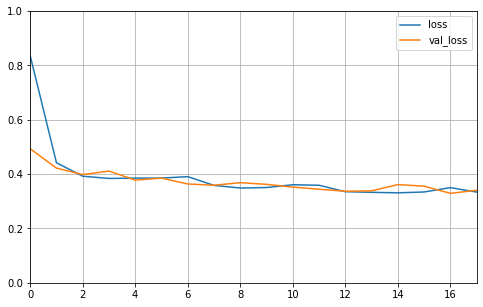

In [8]:
plot_learning_curves(history)

In [9]:
# 2.定义参数集合，即搜索空间
# 使用一个分布，生成在连续空间中最小值到最大值的取值，用来生成学习率
# f(x) = 1/(x * log(b/a))  a<=x<=b
from scipy.stats import reciprocal

param_distribution = {
    "hidden_layers": [1, 2, 3, 4],
    "layer_size": np.arange(1, 100),
    "learning_rate": reciprocal(1e-4, 1e-2),
}

In [ ]:
# 3.按照搜索空间进行搜索
from sklearn.model_selection import RandomizedSearchCV

# RandomizedSearchCV默认使用3折cross_validation：训练集分成n份，n-1训练，最后一份验证
random_search_cv = RandomizedSearchCV(sklearn_model,param_distribution,
                                      cv=3,n_iter=10,n_jobs=1)
random_search_cv.fit(x_train_scaled, y_train, epochs=100,
                     validation_data = (x_valid_scaled,y_valid),
                     callbacks = callbacks)

In [13]:
# 打印最优参数、分数、模型
print(random_search_cv.best_params_)
print(random_search_cv.best_score_)
# print(random_search_cv.best_estimator_)

{'hidden_layers': 3, 'layer_size': 50, 'learning_rate': 0.0010951588862015238}
-0.3051839210574325


In [ ]:
model = random_search_cv.best_estimator_.model
model.evaluate(x_test_scaled,y_test)